In [4]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [5]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [6]:
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [7]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [10]:
# which user has the highest number of reply counts?
data = SlackDataLoader('../anonymized/')
data_week8 = data.slack_parser('../anonymized/*/')

In [11]:
data_week8.head()

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,<!here> we're on gmeet...if you're online join us,Judith Bolton,1663139588.116659,broadcast,0,0,0,0,0,
1,message,<@U03UH397319> <https://anderfernandez.com/en/...,Judith Bolton,1663142046.799109,user,0,0,0,0,0,
2,message,when running your API try `python3 -m uvicorn ...,Judith Bolton,1663142094.022539,text,0,0,0,0,0,
3,message,Well received with thanks <@U03UJGP0C68>,Brenda Hernandez,1663142486.253059,text,0,0,0,0,0,
4,message,Good afternoon everyone. I am sorry for having...,Brian Odom,1663151073.400859,text,1663151073.400859,2,2,"U03UH397319,U03UJKJGRAQ",1663154349.239879,


In [ ]:

data_sorted = data_week8.sort_values(by='reply_count', ascending=False)
data_sorted.head(10)['sender_name']

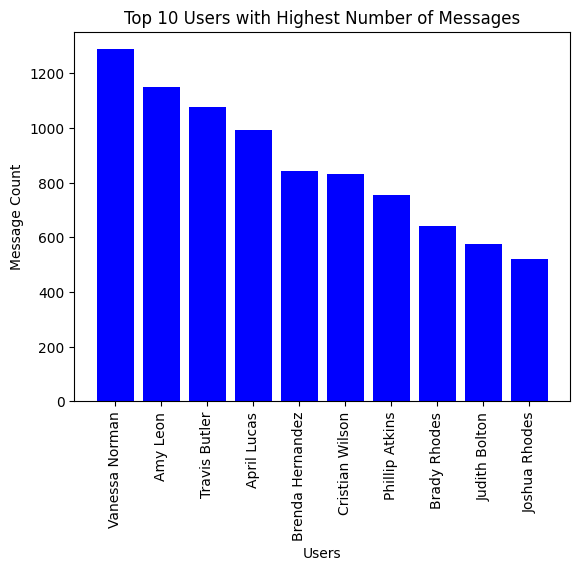

In [27]:
# which user has the highest number of messages?
message_counts = data_week8['sender_name'].value_counts()
data_sort = data_week8.groupby('sender_name').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
plt.bar(data_sort['sender_name'][:10], data_sort['counts'][:10], color='blue')
plt.xticks(rotation=90)
plt.xlabel('Users')
plt.ylabel('Message Count')
plt.title('Top 10 Users with Highest Number of Messages')
plt.show()



In [52]:
#users with few messages count
data_sort.tail(10)['sender_name']

35          Leah Newton
46      Patricia Thomas
50         Randy Miller
47    Patrick Hernandez
54             Slackbot
14     Christopher Case
25       Holly Whitaker
22          Erica Munoz
17          David Scott
6           Blake Scott
Name: sender_name, dtype: object

Text(0, 0.5, 'Reply Count')

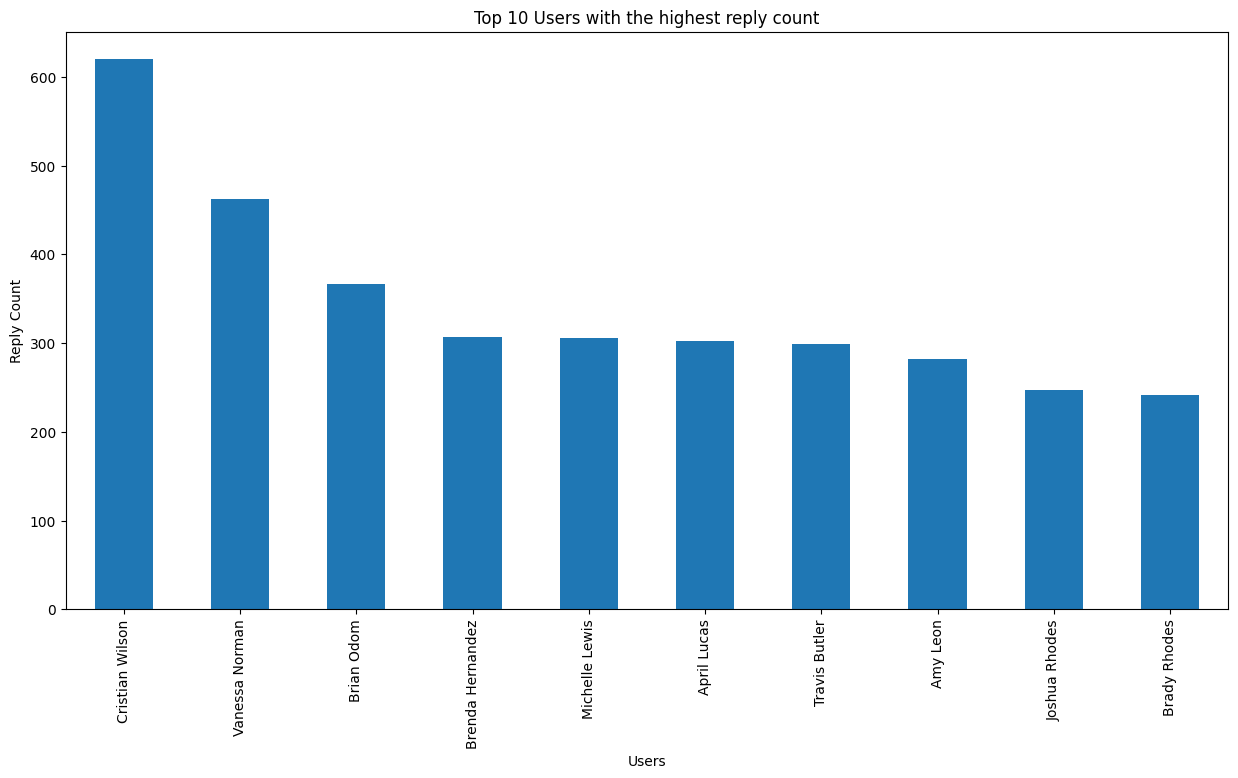

In [26]:
# Visualize reply counts per user per channel
data_week8.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
plt.title("Top 10 Users with the highest reply count")
plt.xlabel('Users')
plt.ylabel('Reply Count')

In [10]:
# what is the time range of the day that most messages are sent?
data_week8['Timestamp'] = utils.convert_2_timestamp('msg_sent_time', data_week8)
#data_week8['Timestamp'] = convert_2_timestamp('msg_sent_time', data_week8)
data_week8['Hour'] = data_week8['Timestamp'].dt.hour
data_week8['Minute'] = data_week8['Timestamp'].dt.minute
interval_minutes = 60
data_week8['TimeInterval'] = (data_week8['Hour'] * 60 + data_week8['Minute']) // interval_minutes
time_interval_counts = data_week8['TimeInterval'].value_counts()
most_frequent_interval = time_interval_counts.idxmax()

/home/basilel/Desktop/for git/slack_messages_analysis/src/utils.py:179: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  timestamp = pd.to_datetime(time_unix, unit='s')


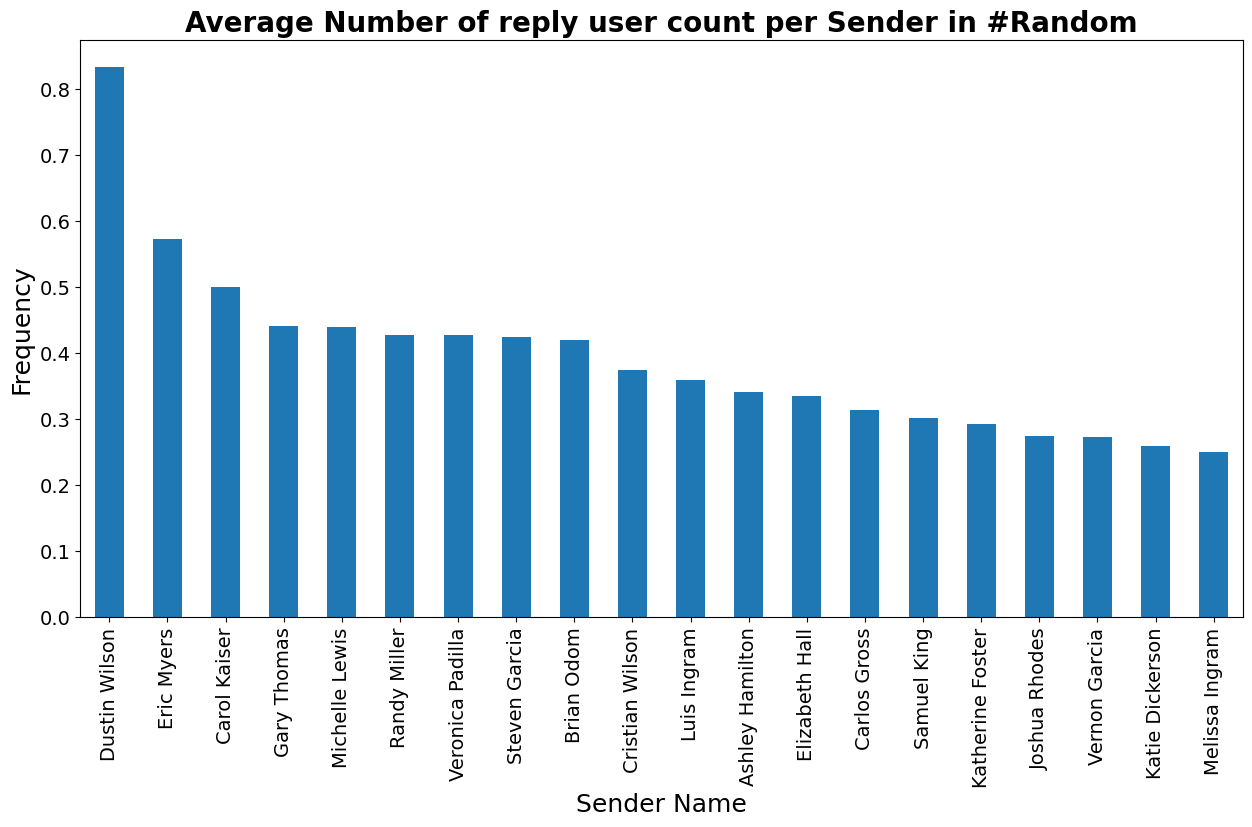

In [33]:
data_Random = SlackDataLoader('../anonymized/')
draw_avg_reply_users_count(data=data_Random.slack_parser('../anonymized/*/'), channel='Random')
#data_week8

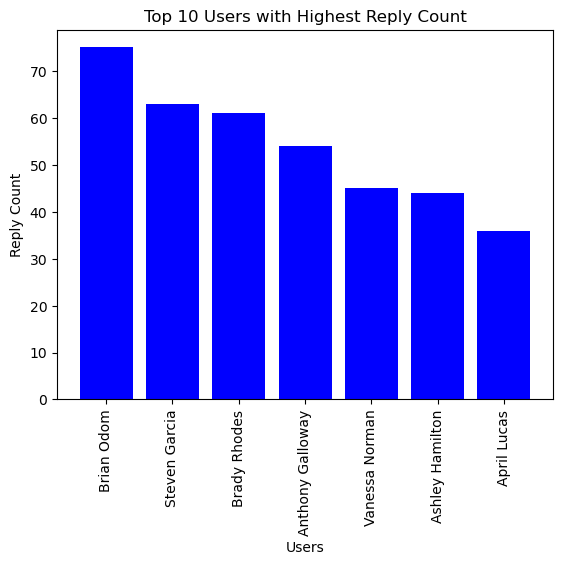

In [46]:
#plot of top users with highest replies per message.

top_users = data_week8.sort_values(by='reply_count', ascending=False).head(10)
plt.bar(top_users['sender_name'], top_users['reply_count'], color='blue')
plt.xticks(rotation=90)
plt.xlabel('Users')
plt.ylabel('Reply Count')
plt.title('Top 10 Users with Highest Reply Count')
plt.show()


In [12]:
# Relationship between # of messages and # of reactions


In [13]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [14]:
# Which users got the most reactions?

In [15]:
# Model topics mentioned in the channel

In [16]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [17]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?